<a href="https://colab.research.google.com/github/lmaheshds/EVA6-Assignment9-RHRF/blob/main/Assign9v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU Verification

In [2]:
!pip install torchsummary

In [3]:
import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


Albumentation install

In [4]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 8.4MB/s 
     |████████████████████████████████| 952kB 35.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=c25dd15d964377d51860a7cac380c976586644e20667b57904f1bf5810d29b27
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Cloning Git Repo

In [5]:
!git clone "https://github.com/lmaheshds/EVA6-Assignment9-RHRF.git"

Cloning into 'EVA6-Assignment9-RHRF'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 139 (delta 49), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (139/139), 572.05 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (49/49), done.


Change Directory

In [6]:
%cd "EVA6-Assignment9-RHRF/Allfiles/"

/content/EVA6-Assignment9-RHRF/Allfiles


CIFAR-10 Data Loading Libraries

In [7]:
from torch.utils.data.dataloader import DataLoader
from dataloader import ImageDataLoader
from torchvision.datasets import CIFAR10
from datatransform import CIFAR10Transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from resnetmodels import CustomResNet
from traintest import Learner
import torch
import torch.optim as optim
from learningratefinder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from differencer import Interpreter

Data Loading

In [8]:
train_dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())


Extracting data/cifar-10-python.tar.gz to data/


In [9]:
len(train_dataset)

50000

In [10]:
len(test_dataset)

10000

In [39]:
batch_size = 512

In [13]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])


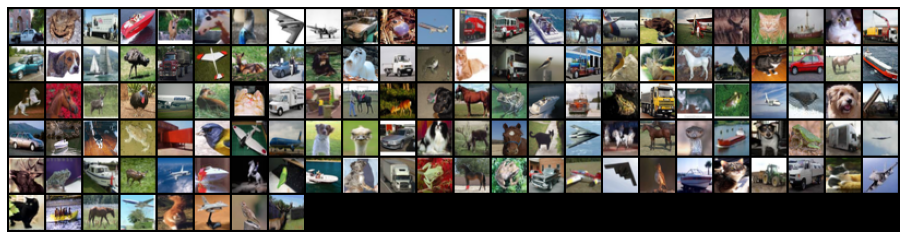

In [20]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,24))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=24).permute((1, 2, 0)))
    break

# classes

In [22]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [23]:
class_count = {}
for _, index in train_dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

# Train and Test images before Transformation

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


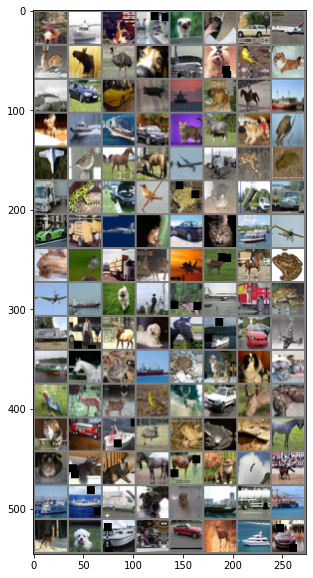

In [24]:
image_loader.show(dataset_type='train')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


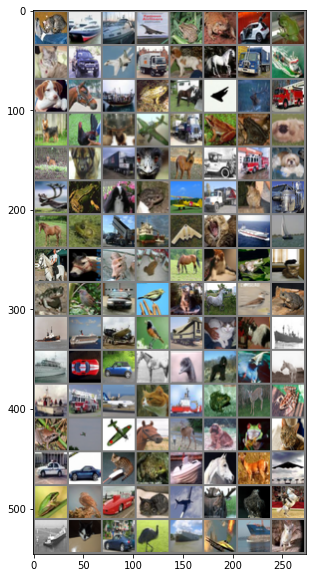

In [25]:
image_loader.show(dataset_type='test')

In [40]:
DATA_DIR = 'data'
cifar10 = CIFAR10Transforms()
custom_train_tfms = [A.PadIfNeeded(min_height=40,min_width=40), 
                     A.RandomCrop(32, 32, p=1.0),
                     A.HorizontalFlip(),
                     A.Cutout(num_holes=2, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.1),
                     ]
train_transform,  test_transform = cifar10.build_transforms(train_tfms_list=custom_train_tfms, test_tfms_list=[])
image_loader = ImageDataLoader(train_transform, test_transform, DATA_DIR, batch_size, True, 'CIFAR10', figure_size=(20,10))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Custom ResNet Architecture

In [41]:
criterion = F.nll_loss #(Negative Log loss)
cnn_learner = Learner(train_loader=image_loader.train_loader, test_loader=image_loader.test_loader, model=CustomResNet(),loss_func=criterion)

Model Summary

In [42]:
cnn_learner.summary(input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

# Learning rates

LR Minimum

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.01E-03


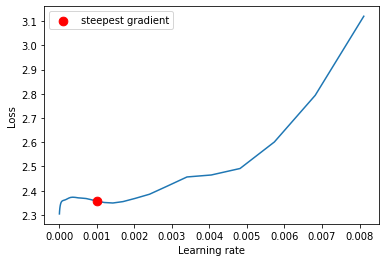

In [29]:
optimizer=optim.SGD(cnn_learner.model.parameters(), lr=1e-7, momentum=0.9, weight_decay=cnn_learner.weight_decay)
lr_finder = LRFinder(cnn_learner.model, optimizer, criterion, device="cuda" )
lr_finder.range_test(train_loader=image_loader.train_loader, val_loader=image_loader.test_loader, end_lr=3, num_iter=100)
lr_finder.plot(log_lr=False)
lr_finder.reset()

LR Maximum

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.05E-01


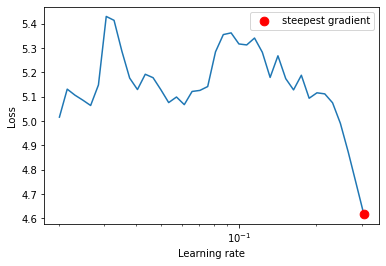

In [30]:
optimizer=optim.SGD(cnn_learner.model.parameters(), lr=1e-2, momentum=0.9, weight_decay=cnn_learner.weight_decay)
lr_finder = LRFinder(cnn_learner.model, optimizer, criterion, device="cuda" )
lr_finder.range_test(image_loader.train_loader, end_lr=10, num_iter=100)
lr_finder.plot(log_lr=True)
lr_finder.reset()

Training the model

In [56]:
lr_max= 3.05E-01
lr_min = 1.01E-03
optimizer=optim.SGD(cnn_learner.model.parameters(), lr=0.073, momentum=0.9, weight_decay=cnn_learner.weight_decay)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=490, step_size_down=1470)

In [57]:
cnn_learner.fit_custom(25,optimizer,lr_scheduler,pass_loss=False)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.02591809816658497 Batch_id=97 Accuracy=98.39: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4087, Accuracy: 9100/10000 (91.00%)

EPOCH: 1


Loss=0.04247564449906349 Batch_id=97 Accuracy=98.86: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4041, Accuracy: 9116/10000 (91.16%)

EPOCH: 2


Loss=0.04718628153204918 Batch_id=97 Accuracy=99.05: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3916, Accuracy: 9118/10000 (91.18%)

EPOCH: 3


Loss=0.014790941961109638 Batch_id=97 Accuracy=99.09: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3921, Accuracy: 9145/10000 (91.45%)

EPOCH: 4


Loss=0.017021343111991882 Batch_id=97 Accuracy=99.19: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3996, Accuracy: 9114/10000 (91.14%)

EPOCH: 5


Loss=0.06368862837553024 Batch_id=97 Accuracy=99.24: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3964, Accuracy: 9130/10000 (91.30%)

EPOCH: 6


Loss=0.02399713732302189 Batch_id=97 Accuracy=99.32: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3942, Accuracy: 9136/10000 (91.36%)

EPOCH: 7


Loss=0.034275609999895096 Batch_id=97 Accuracy=99.33: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3915, Accuracy: 9150/10000 (91.50%)

EPOCH: 8


Loss=0.013462234288454056 Batch_id=97 Accuracy=99.26: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4037, Accuracy: 9115/10000 (91.15%)

EPOCH: 9


Loss=0.017134280875325203 Batch_id=97 Accuracy=99.34: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4093, Accuracy: 9139/10000 (91.39%)

EPOCH: 10


Loss=0.03239155560731888 Batch_id=97 Accuracy=99.28: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4064, Accuracy: 9108/10000 (91.08%)

EPOCH: 11


Loss=0.027199603617191315 Batch_id=97 Accuracy=99.26: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4028, Accuracy: 9112/10000 (91.12%)

EPOCH: 12


Loss=0.030943801626563072 Batch_id=97 Accuracy=99.25: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4017, Accuracy: 9149/10000 (91.49%)

EPOCH: 13


Loss=0.02127600461244583 Batch_id=97 Accuracy=99.18: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4307, Accuracy: 9091/10000 (90.91%)

EPOCH: 14


Loss=0.009561902843415737 Batch_id=97 Accuracy=99.34: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4143, Accuracy: 9112/10000 (91.12%)

EPOCH: 15


Loss=0.024961773306131363 Batch_id=97 Accuracy=99.24: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4246, Accuracy: 9092/10000 (90.92%)

EPOCH: 16


Loss=0.040844328701496124 Batch_id=97 Accuracy=99.10: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4418, Accuracy: 9047/10000 (90.47%)

EPOCH: 17


Loss=0.023564686998724937 Batch_id=97 Accuracy=98.99: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4880, Accuracy: 8994/10000 (89.94%)

EPOCH: 18


Loss=0.0225363839417696 Batch_id=97 Accuracy=98.87: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5086, Accuracy: 8960/10000 (89.60%)

EPOCH: 19


Loss=0.048334211111068726 Batch_id=97 Accuracy=98.73: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5105, Accuracy: 8978/10000 (89.78%)

EPOCH: 20


Loss=0.012756722047924995 Batch_id=97 Accuracy=98.74: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4934, Accuracy: 9025/10000 (90.25%)

EPOCH: 21


Loss=0.056724872440099716 Batch_id=97 Accuracy=98.34: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5035, Accuracy: 8962/10000 (89.62%)

EPOCH: 22


Loss=0.0890670195221901 Batch_id=97 Accuracy=98.10: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4960, Accuracy: 8971/10000 (89.71%)

EPOCH: 23


Loss=0.04358283057808876 Batch_id=97 Accuracy=97.99: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5684, Accuracy: 8876/10000 (88.76%)

EPOCH: 24


Loss=0.02935701049864292 Batch_id=97 Accuracy=97.79: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]



Test set: Average loss: 0.5241, Accuracy: 8903/10000 (89.03%)



Plot Losses and Accuracy

In [ ]:
cnn_learner.plot_losses()

Test data Learner

In [ ]:
intrepret = Interpreter(model=cnn_learner.model, dataloader=image_loader.test_loader, classes=image_loader.classes)

Confusion Matrix

In [ ]:
intrepret.plot_confusion_matrix()

Performance Metrics

In [ ]:
intrepret.show_classification_report()